In [3]:
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import re
import timeit

pd.options.display.max_rows = 4000

In [4]:

# Pulling data from ANRGUSC github
df = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19-R.csv')
df_infection = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19.csv')
df_county_names = pd.read_csv('county_storage.csv')

# Converting String into Datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])  
df_infection['Time Stamp'] = pd.to_datetime(df_infection['Time Stamp'])  

# Dropping 'Latitude' and 'Longitude' columns from df_infection
df_infection = df_infection.drop(['Latitude', 'Longitude'], axis=1)

# Combining two tables together
df = pd.merge(df, df_infection,  how='left', left_on=['Time Stamp','Region'], right_on = ['Time Stamp','Region'])

# Changing Region Name to Upper Case

df['Region'] = df['Region'].str.upper()

In [5]:
"""This is for combining umich3"""

# # Pulling data from Umich3 github
# df_umich3 = pd.read_csv('https://raw.githubusercontent.com/sli525/rmds-lab-team3-project/master/output%20file/risk_level.csv')

# # Data Cleaning
# df_umich3['Region'] = df_umich3['Region'].str.upper()
# df_infection['Region'] = df_infection['Region'].str.upper()

# df_umich3['Timestamp'] = pd.to_datetime(df_umich3['Timestamp'])  
# df_umich3=df_umich3.rename(columns={"Timestamp": "Time Stamp", "Risk_score": "Risk-Score", "Risk_level":"Risk-Level"})

# # Mering Umich3 data with infection data
# df_umich3= pd.merge(df_umich3, df_infection,  how='left', left_on=['Time Stamp','Region'], right_on = ['Time Stamp','Region'])

'This is for combining umich3'

In [6]:
# Converting String into Datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])

# Dropping Any Data with no Risk Score
df=df[df['Risk-Score']!=-1]

# renaming the first column to index
df=df.rename(columns={"Unnamed: 0": "index"})


In [7]:
# Defining LA county and LA city 


unique_regions = df_county_names['location'].unique()


pattern="^LOS ANGELES - "

extr_region=df_county_names['location'].str.contains(pattern)
los_angeles_region = df_county_names[extr_region]['location']


los_angeles_region=los_angeles_region.str.replace('LOS ANGELES - ','').unique()

        

In [8]:
regions = df['Region'].unique()
df_new=df.copy()

df_new_cases = pd.DataFrame()

for region in regions:
    df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
    for date in df_region['Time Stamp']:
        day_before = date - dt.timedelta(days=1)
        df_on_day = df_region[df_region['Time Stamp']==date]
        
        cases_on_day = df_on_day['Number of cases']
        cases_day_before = df_region[df_region['Time Stamp']==day_before]['Number of cases']
        
        if not cases_day_before.empty:
            new_cases = cases_on_day.iloc[0] - cases_day_before.iloc[0]
        
        
            new_row = {'index':df_on_day['index'].iloc[0], 'New Cases':new_cases}
        #append row to the dataframe
            df_new_cases = df_new_cases.append(new_row, ignore_index=True)

In [9]:
# Adding new cases data into df
df = pd.merge(left=df, right=df_new_cases, how='left', on='index')

In [10]:
# Finding out what Risk Level correspondes to

df_0 = df[df['Risk-Level']==0]['Risk-Score']
df_1 = df[df['Risk-Level']==1]['Risk-Score']
df_2 = df[df['Risk-Level']==2]['Risk-Score']
df_3 = df[df['Risk-Level']==3]['Risk-Score']

print("Level 0 is between %f and %f" %(min(df_0),max(df_0)))
print("Level 1 is between %f and %f" %(min(df_1),max(df_1)))
print("Level 2 is between %f and %f" %(min(df_2),max(df_2)))
print("Level 3 is between %f and %f" %(min(df_3),max(df_3)))

Level 0 is between 0.000000 and 0.099892
Level 1 is between 0.100022 and 0.999895
Level 2 is between 1.000413 and 1.999766
Level 3 is between 2.000270 and 412.651620


In [11]:
# This function calculates trend of the Risk-Score overtime.
# Input:  area:               this can be either 'all' or specific name of the region
#         length1:            these parameters define the windows of the rolling/moving average
# Output: df_updated:         this new dataframe contains new rolling averages, and risk-score difference in addition to original data

def calc_risk_trend(area, length1):
    df_recent_1= pd.DataFrame()
    df_rolling_1= pd.DataFrame()
    df_rolling_cases = pd.DataFrame()
    
    if area == 'LA COUNTY': # if 'all' is given, iterate through all regions in the data
        regions = 'LA COUNTY'
        df_mean = df.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA COUNTY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
    elif area == 'LA CITY':
        df_la = df.copy()
        df_la = df_la[df_la['Region'].isin(los_angeles_region)]
        df_mean = df_la.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df_la.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA CITY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
        
    else:
        df_new=df.copy()
        df_new = df_new[df_new['Region']==area]
    
    df_region = df_new.sort_values('Time Stamp')
    # defining specific dates that we are going to pull data from
    recent_date = max(df_region['Time Stamp'])
    length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
    
    
    # pulling data matching dates defined
    df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
    df_recent = df_region[df_region['Time Stamp']==recent_date]
    

    # calculating rolling averages
    rolling_rs_1 = df_region['Risk-Score'].rolling(length1, min_periods=1).mean()
    rolling_cases = df_region['New Cases'].rolling(length1, min_periods=1).mean()
    
    df_rolling_1 = df_rolling_1.append(rolling_rs_1)
    df_rolling_cases = df_rolling_cases.append(rolling_cases)
    
    df_rolling_1_sum = df_rolling_1.sum(skipna = True, axis=0)
    df_rolling_cases_sum = df_rolling_cases.sum(skipna = True, axis=0)
    

    rolling_1 = pd.DataFrame()
    rolling_c = pd.DataFrame()

    string3 = "Risk Score Rolling Avg"

    rolling_1[string3]=df_rolling_1_sum
    rolling_c['New Cases Rolling Avg']=df_rolling_cases_sum

    df_updated = df_region.merge(rolling_1, left_index=True, right_index=True, how='left')
    df_updated = df_updated.merge(rolling_c, left_index=True, right_index=True, how='left')
    
    df_updated['Rolling Diff'] = df_updated[string3].diff()
    
    df_updated = df_updated.sort_values('Time Stamp')
    
    return df_updated


In [12]:
calc_risk_trend('HOLLYWOOD', 18)

,index,Time Stamp,Region,Latitude,Longitude,Risk-Score,Risk-Level,Number of cases,New Cases,Risk Score Rolling Avg,New Cases Rolling Avg,Rolling Diff
45,45,2020-03-17,HOLLYWOOD,34.098003,-118.329523,0.549663,1,1,NaN,0.549663,0.000000,NaN
87,87,2020-03-18,HOLLYWOOD,34.098003,-118.329523,0.547101,1,5,4.0,0.548382,4.000000,-0.001281
141,141,2020-03-19,HOLLYWOOD,34.098003,-118.329523,0.731610,1,5,0.0,0.609458,2.000000,0.061076
213,214,2020-03-20,HOLLYWOOD,34.098003,-118.329523,1.153413,2,7,2.0,0.745447,2.000000,0.135989
295,297,2020-03-21,HOLLYWOOD,34.098003,-118.329523,1.756542,2,12,5.0,0.947666,2.750000,0.202219
392,395,2020-03-22,HOLLYWOOD,34.098003,-118.329523,2.318666,3,12,0.0,1.176166,2.200000,0.228500
496,500,2020-03-23,HOLLYWOOD,34.098003,-118.329523,2.642458,3,14,2.0,1.385636,2.166667,0.209470
611,616,2020-03-24,HOLLYWOOD,34.098003,-118.329523,2.662236,3,19,5.0,1.545211,2.571429,0.159575
737,743,2020-03-25,HOLLYWOOD,34.098003,-118.329523,2.400759,3,23,4.0,1.640272,2.750000,0.095061
870,877,2020-03-26,HOLLYWOOD,34.098003,-118.329523,2.001838,3,27,4.0,1.676429,2.888889,0.036157


In [13]:

# this function uses calc_risk_trend function to calculate the rolling average and creates a time-series plot
# this function only works when a specific region is given

def plot_rs(city_name,length1,plot_new_case_or_not):
    
    df_final = calc_risk_trend(city_name, length1)
    df_a = df[df['Region']==city_name].sort_values('Time Stamp')
    fig = plt.figure(figsize=(20,10))
    ax_left = fig.add_subplot()
    ax_right = ax_left.twinx()
    
    string3 = "Risk Score Rolling Avg"

    
    if plot_new_case_or_not == 'All':
    
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns3 = ax_right.plot('Time Stamp','New Cases', data =df_final, color='green')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')
        lns5 = ax_left.plot('Time Stamp','Rolling Diff', data =df_final, color='purple')

        lns = lns1+lns2+lns3+lns4+lns5
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases'])
        y_max_right = y_max_right + y_max_right/3
    

        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20, fontweight='bold')
    
    elif plot_new_case_or_not == 'Only Risk Score':
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
 
        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)


        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        
    

        ax_left.set_ylim(0, y_max)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20, fontweight='bold')
    
    
    elif plot_new_case_or_not == 'Raw':
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        
        lns3 = ax_right.plot('Time Stamp','New Cases', data =df_final, color='green')
        

        lns = lns1+lns3
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases'])
        y_max_right = y_max_right + y_max_right/3
    

        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20, fontweight='bold')
        
    elif plot_new_case_or_not == 'Risk Diff':
    
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns3 = ax_right.plot('Time Stamp','Rolling Diff', data =df_final, color='blue')

        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Risk Score Differences",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['Rolling Diff'])
        y_max_right = y_max_right + y_max_right/3
        y_min_right = min(df_new_case_drop['Rolling Diff'])
        y_min_right = y_min_right + y_min_right/3
    

        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(-y_max_right,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20, fontweight='bold')
    
    else:
        
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')

        lns = lns1+lns2+lns4
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])


        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases Rolling Avg'])
        y_max_right = y_max_right + y_max_right/3
    
  
        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20, fontweight='bold')
    
    if plot_new_case_or_not == 'Risk Diff':
        ax_right.axhspan(-0.143,0.143, color='green', alpha=0.1)
        ax_right.axhspan(-30,-0.143, color='red', alpha=0.1)
        ax_right.axhspan(0.143,30, color='red', alpha=0.1)
    else:
        ax_left.axhspan(0.1,1, color='blue', alpha=0.1)
        ax_left.axhspan(0,0.1, color='green', alpha=0.1)
        ax_left.axhspan(0.1,1, color='blue', alpha=0.1)
        ax_left.axhspan(1,2, color='yellow', alpha=0.1)
        ax_left.axhspan(2,y_max+10, color='red', alpha=0.1)
    
    x_line_annotation_1 = dt.datetime(2020, 3, 19)
    x_text_annotation_1 = dt.datetime(2020, 3, 16)
    
    x_line_annotation_2 = dt.datetime(2020, 5, 8)
    x_text_annotation_2 = dt.datetime(2020, 5, 5)
    
    x_line_annotation_3 = dt.datetime(2020, 6, 12)
    x_text_annotation_3 = dt.datetime(2020, 6, 9)
    
    x_line_annotation_4 = dt.datetime(2020, 7, 1)
    x_text_annotation_4 = dt.datetime(2020, 6, 28)
    
    ax_left.axvline(x=x_line_annotation_1, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_1, y=y_max-y_max/4,fontsize=15, s='Stage 1', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_2, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_2, y=y_max-y_max/5,fontsize=15, s='Stage 2', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_3, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_3, y=y_max-y_max/5,fontsize=15, s='Stage 3', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_4, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_4, y=y_max-y_max/5,fontsize=15, s='Reclosure', alpha=1, color='#334f8d',rotation='vertical')
    
    
    

        
        
#         min_date=min(df_final['Time Stamp']) - dt.timedelta(days=5)
#         max_date=max(df_final['Time Stamp']) + dt.timedelta(days=5)
#         ax_left.set_xlim([min_date, max_date])
#         ax_left.axvspan(*mdates.datestr2num(['03/19/2020', '05/08/2020']), color='red', alpha=0.1)
#         ax_left.axvspan(*mdates.datestr2num(['05/08/2020', '06/12/2020']), color='yellow', alpha=0.1)
#         ax_left.axvspan(*mdates.datestr2num(['06/12/2020', '07/01/2020']), color='blue', alpha=0.1)
#         ax_left.axvspan(*mdates.datestr2num(['07/01/2020', '09/13/2020']), color='red', alpha=0.1)
#         ax_left.annotate('Reopen:Stage 1', xy=(200, 550), xycoords='figure pixels',alpha=0.5,fontsize = 18)
#         ax_left.annotate('Reopen:Stage 2', xy=(480, 550), xycoords='figure pixels',alpha=0.5,fontsize = 18)
#         ax_left.annotate('Reopen:\n Stage 3', xy=(700, 530), xycoords='figure pixels',alpha=0.5,fontsize = 18)   
#         ax_left.annotate('Re-closure', xy=(950, 550), xycoords='figure pixels',alpha=0.5,fontsize = 18)
    plt.show()

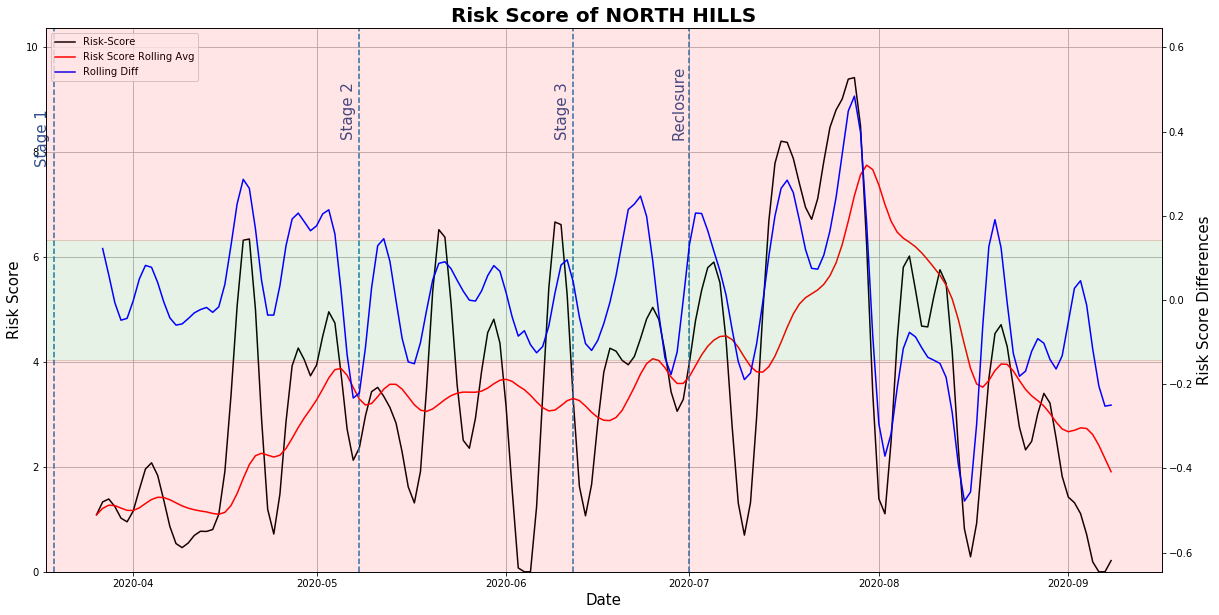

In [14]:
plot_rs('NORTH HILLS', 18, 'Risk Diff')

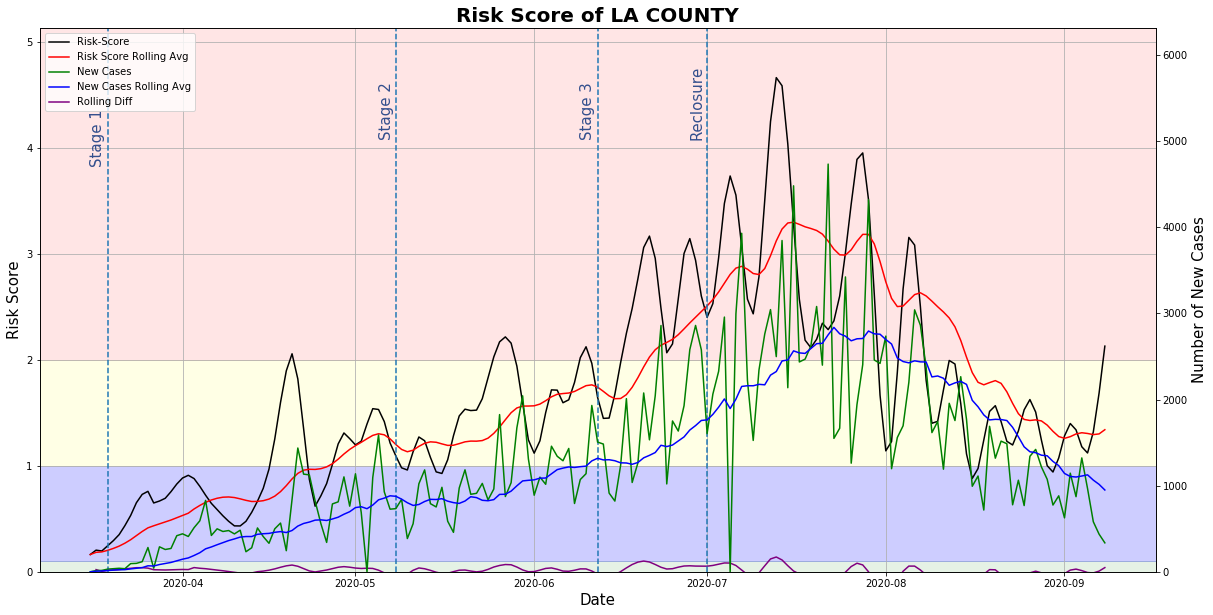

In [15]:
a=plot_rs('LA COUNTY', 18, 'All')

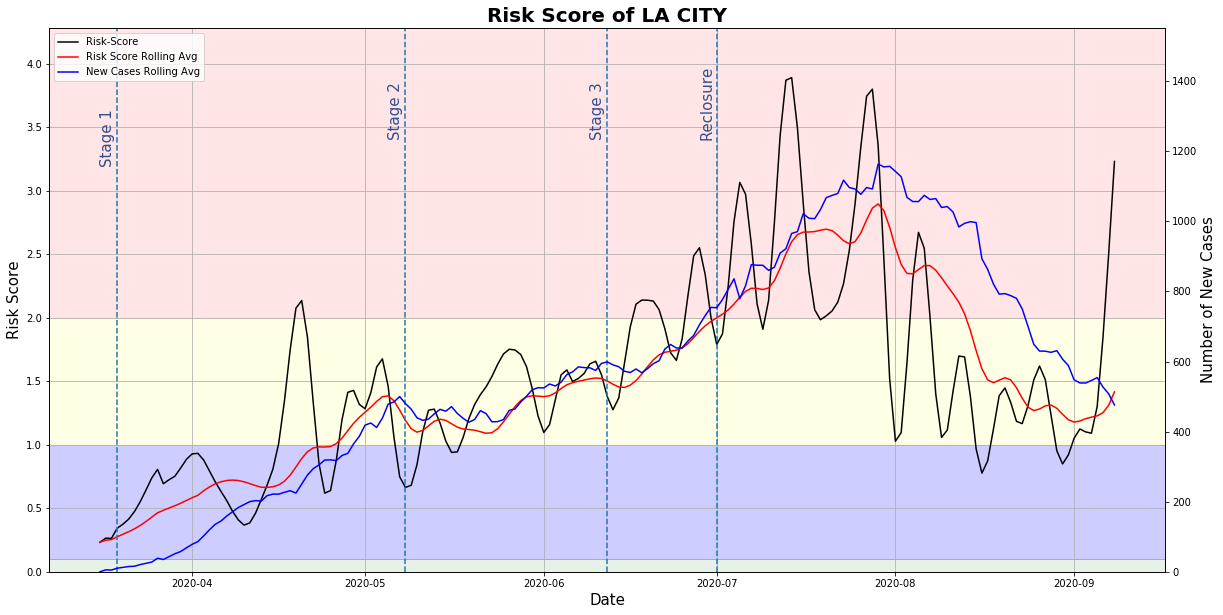

In [16]:
a=plot_rs('LA CITY', 18, '')

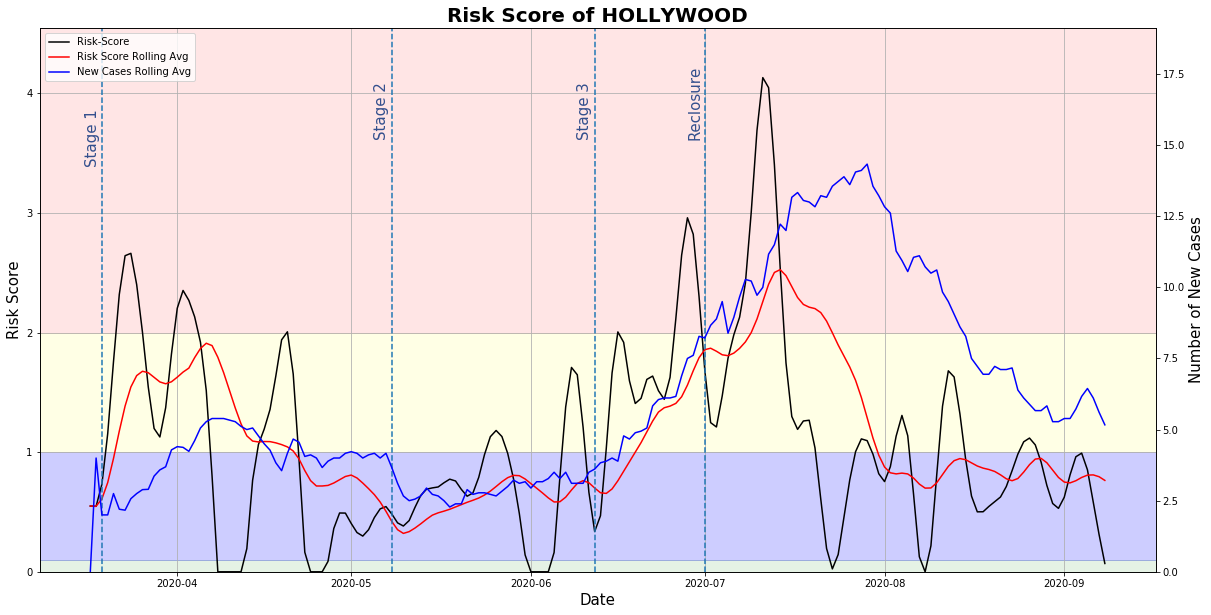

In [17]:
plot_rs('HOLLYWOOD',18,'')

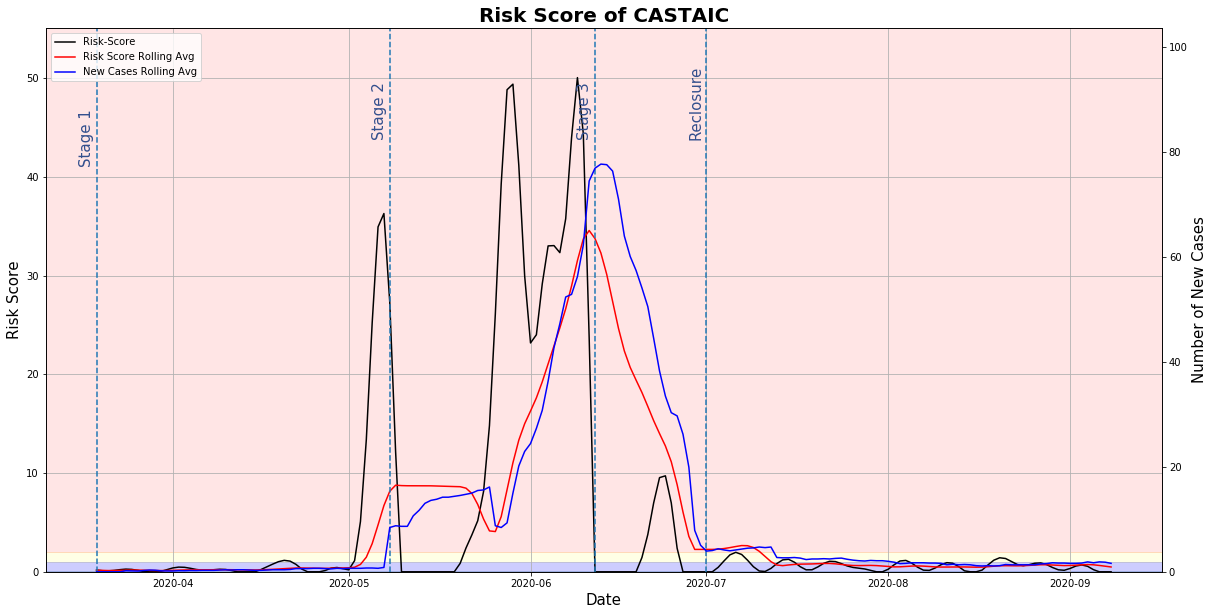

In [18]:
plot_rs('CASTAIC',18,'')

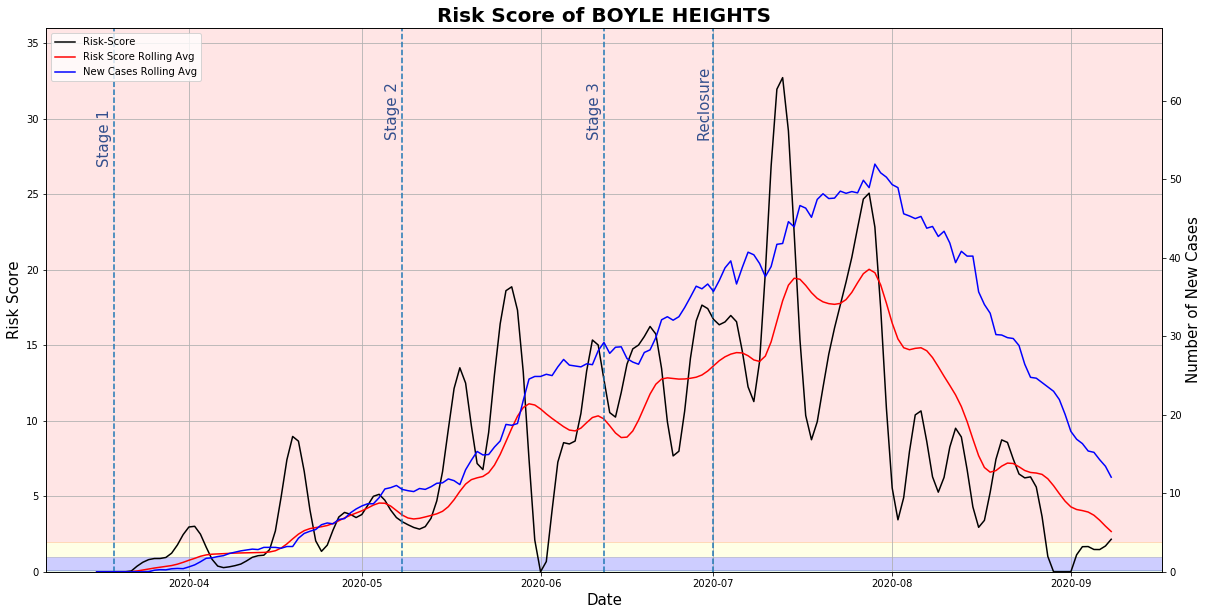

In [19]:
plot_rs('BOYLE HEIGHTS',18,'')

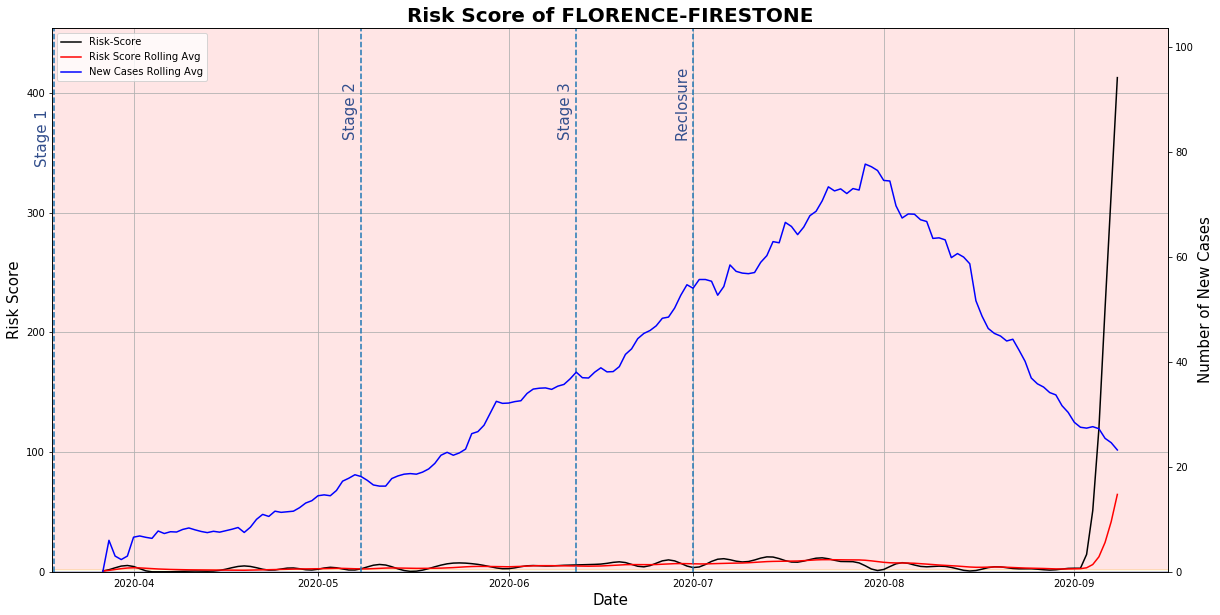

In [20]:
plot_rs('FLORENCE-FIRESTONE',18,'')

In [21]:
# This function calculates trend of the Risk-Score at the most current data and ranks them.
# Input:  No Inputs Needed. The function takes 18 days rolling average difference of each regions.
# Output: CSV file that contains list of all regions with calculated Risk Score Trends on the most current data

def rs_trend_recent():
    
    #intializing variables
    recent = pd.DataFrame()
    df_recent_1= pd.DataFrame()
    df_recent_2= pd.DataFrame()
    recent
    
    df_new=df.copy()
    regions = df_new['Region'].unique()
#     recent['Region']=regions
#     recent['Date']=recent['Region']
    
    
    for region in regions:
        df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
        
        recent_date = max(df_region['Time Stamp'])
#
        df_recent = df_region[df_region['Time Stamp']==recent_date]
        
        
        
        #Rolling Avreage
       
        rolling_rs = df_region['Risk-Score'].rolling(18, min_periods=1).mean()

        recent_rolling_rs = rolling_rs.iloc[-1]

        past_rolling_rs = rolling_rs.iloc[-2]

        rolling_diff_rs = recent_rolling_rs - past_rolling_rs



        df_recent["Current_Rolling_Average"] = recent_rolling_rs
        df_recent["Past_Rolling_Average"] = past_rolling_rs
        df_recent["RS Diff"] = rolling_diff_rs


        threshhold=1/10

        if rolling_diff_rs > threshhold:
            df_recent['Trend'] = 'UP'
        if (rolling_diff_rs < threshhold) & (rolling_diff_rs > -threshhold):
            df_recent['Trend'] = 'Neutral'
        if rolling_diff_rs < -threshhold:
            df_recent['Trend'] = 'DOWN'

                
                
#             percent_change = (rolling_diff_rs)*100/past_rolling_rs
#             percent_threshhold = 5
#             df_recent['Percent Change']=round(percent_change)

#             if percent_change > percent_threshhold:
#                 df_recent['Trend (%)'] = 'UP'
#             if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
#                 df_recent['Trend (%)'] = 'Neutral'
#             if percent_change < -percent_threshhold:
#                 df_recent['Trend (%)'] = 'DOWN'
        
#         if rolling_diff > threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Red'
#         if (rolling_diff < threshhold) & (rolling_diff > -threshhold):
#             df_recent['Risk_Trend_Abs'] = 'Yellow'
#         if rolling_diff < -threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Green'


        
            
            
            
        
        recent = recent.append(df_recent).sort_values('Time Stamp')
    recent["Rank"] = recent["RS Diff"].rank(ascending=False)
    recent["Rank"] = recent["Rank"].astype(int)
    recent = recent.sort_values('Rank')
    recent=recent.rename(columns={"New Cases": "Daily New Cases"})
#         recent= recent.rename(columns={"A": "a", "B": "c"})
#         recent=recent.drop(['index','Time Stamp','Latitude', 'Longitude','RS_change_3_Days','RS_change_14_Days'], axis=1)
    recent = recent[['Time Stamp','Region','Daily New Cases','Risk-Score','Risk-Level','Rank','RS Diff','Trend']]
    recent=recent.reset_index(drop=True)
    recent.to_csv(r'C:\Users\kwonk\Guided Project\Covid_Challenge_KooHa\Covid_19_Challenge\risk_score_trend\output\rs_trend_recent.csv')
    return recent

In [22]:
rs_trend_recent()

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,Time Stamp,Region,Daily New Cases,Risk-Score,Risk-Level,Rank,RS Diff,Trend
0,2020-09-08,FLORENCE-FIRESTONE,8.0,412.651620,3,1,22.736304,UP
1,2020-09-08,EL SEGUNDO,2.0,14.940786,3,2,0.798713,UP
2,2020-09-08,AVALON,0.0,4.920869,3,3,0.273382,UP
3,2020-09-08,JEFFERSON PARK,0.0,1.904912,2,4,0.079113,Neutral
4,2020-09-08,ENCINO,2.0,1.680137,2,5,0.076336,Neutral
5,2020-09-08,PARAMOUNT,7.0,2.249624,3,6,0.074964,Neutral
6,2020-09-08,LAKE LOS ANGELES,4.0,1.041719,2,7,0.057873,Neutral
7,2020-03-26,FLORENCE,3.0,0.138021,1,8,0.034505,Neutral
8,2020-09-08,COMPTON,8.0,1.279334,2,9,0.031263,Neutral
9,2020-09-08,MIRACLE MILE,2.0,0.598422,1,10,0.031165,Neutral


In [23]:
# Function to divide Risk-Score trend into three categories
def trend_cat(row):
    Threshold = 1/10
    if row['RS Diff'] >= Threshold:
        return 'Up'
    elif (-Threshold < row['RS Diff'] <= Threshold):
        return 'Neutral'
    elif row['RS Diff'] <=  -Threshold:
        return 'Down'


In [24]:
# This function calculates trend of the Risk-Score on all past data
# This function doesn't require any input
# Output: saves csv file that contains list of all regions with calculated Risk Score Trends on all past data

def rs_trend_combined():
    
    #intializing variables
    df_prev = pd.DataFrame()

    
    df_new=df.copy()
    regions = df_new['Region'].unique()
    
    for region in regions:
        df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
        
#         recent_date = max(df_region['Time Stamp'])
#         df_recent = df_region[df_region['Time Stamp']==recent_date]
        
        
        
        #Rolling Avreage
        df_region['Rolling Risk-Score'] = df_region['Risk-Score'].rolling(18, min_periods=1).mean()
        df_region['RS Diff']=df_region['Rolling Risk-Score'].diff()
        
        df_prev=df_prev.append(df_region)
    
    df_prev['Trend']=df_prev.apply(trend_cat,axis=1)
    df_prev = df_prev[['Time Stamp','Region','Risk-Score','Risk-Level','New Cases','Rolling Risk-Score','RS Diff', 'Trend']]
    df_prev=df_prev.rename(columns={"New Cases": "Daily New Cases"})
    df_prev=df_prev.reset_index(drop=True)

    df_prev.to_csv(r'C:\Users\kwonk\Guided Project\Covid_Challenge_KooHa\Covid_19_Challenge\risk_score_trend\output\rs_trend_combined.csv')

    return df_prev

In [25]:
rs_trend_combined()

,Time Stamp,Region,Risk-Score,Risk-Level,Daily New Cases,Rolling Risk-Score,RS Diff,Trend
0,2020-03-16,ALHAMBRA,0.158705,1,NaN,0.158705,NaN,None
1,2020-03-17,ALHAMBRA,0.171508,1,-1.0,0.165107,0.006401,Neutral
2,2020-03-18,ALHAMBRA,0.190694,1,0.0,0.173636,0.008529,Neutral
3,2020-03-19,ALHAMBRA,0.200874,1,1.0,0.180445,0.006810,Neutral
4,2020-03-20,ALHAMBRA,0.219765,1,1.0,0.188309,0.007864,Neutral
...,...,...,...,...,...,...,...,...
40493,2020-09-04,WILMINGTON,0.000000,0,8.0,3.179036,-0.285583,Down
40494,2020-09-05,WILMINGTON,0.000000,0,2.0,2.773401,-0.405635,Down
40495,2020-09-06,WILMINGTON,0.000000,0,1.0,2.283988,-0.489413,Down
40496,2020-09-07,WILMINGTON,0.000000,0,2.0,1.821166,-0.462821,Down


In [26]:
recent = rs_trend_recent()
recent

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,Time Stamp,Region,Daily New Cases,Risk-Score,Risk-Level,Rank,RS Diff,Trend
0,2020-09-08,FLORENCE-FIRESTONE,8.0,412.651620,3,1,22.736304,UP
1,2020-09-08,EL SEGUNDO,2.0,14.940786,3,2,0.798713,UP
2,2020-09-08,AVALON,0.0,4.920869,3,3,0.273382,UP
3,2020-09-08,JEFFERSON PARK,0.0,1.904912,2,4,0.079113,Neutral
4,2020-09-08,ENCINO,2.0,1.680137,2,5,0.076336,Neutral
5,2020-09-08,PARAMOUNT,7.0,2.249624,3,6,0.074964,Neutral
6,2020-09-08,LAKE LOS ANGELES,4.0,1.041719,2,7,0.057873,Neutral
7,2020-03-26,FLORENCE,3.0,0.138021,1,8,0.034505,Neutral
8,2020-09-08,COMPTON,8.0,1.279334,2,9,0.031263,Neutral
9,2020-09-08,MIRACLE MILE,2.0,0.598422,1,10,0.031165,Neutral


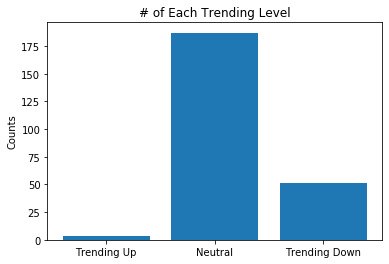

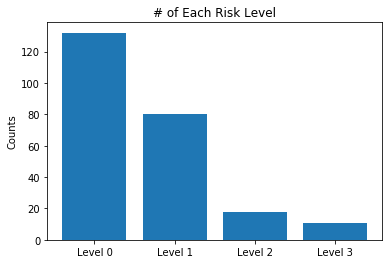

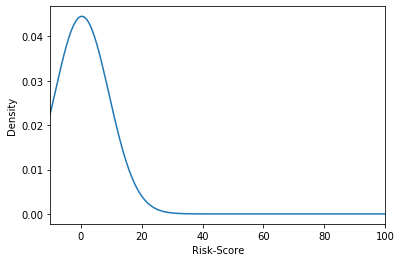

The current average Risk-Score across LA county is 2.111617
The current median Risk-Score across LA county is 0.018640


In [28]:
# Creating bar charts of trend and risk-levels

counts_trend=recent['Trend'].value_counts()
counts_table_trend={'# of Trending Up Regions':[counts_trend['UP']],
              '# of Neutral Trend Regions':[counts_trend['Neutral']],
              '# of Trending Down Regions':[counts_trend['DOWN']]
             }
summary1 = pd.DataFrame(counts_table_trend,columns=['# of Trending Up Regions','# of Neutral Trend Regions','# of Trending Down Regions'])

plt.bar(['Trending Up','Neutral','Trending Down'],[counts_trend['UP'],counts_trend['Neutral'],counts_trend['DOWN']])
plt.ylabel('Counts')
plt.title('# of Each Trending Level')
plt.show()
# print(counts_table)

level_counts=recent['Risk-Level'].value_counts()
counts_table_level={'# of Risk-Level 0 Region':[level_counts[0]],
              '# of Risk-Level 1 Region':[level_counts[1]],
              '# of Risk-Level 2 Region':[level_counts[2]],
              '# of Risk-Level 3 Region':[level_counts[3]]
             }
plt.bar(['Level 0','Level 1','Level 2','Level 3'],[level_counts[0],level_counts[1],level_counts[2],level_counts[3]])
plt.ylabel('Counts')
plt.title('# of Each Risk Level')
plt.show()
# print(counts_table)


recent['Risk-Score'].plot.kde(label='Survived')
plt.xlabel('Risk-Score')
plt.xlim(-10,100)
plt.show()


average_risk_score= recent['Risk-Score'].mean()
median_risk_score = recent['Risk-Score'].median()
print("The current average Risk-Score across LA county is %f" %(average_risk_score))
print("The current median Risk-Score across LA county is %f" %(median_risk_score))


